### Smit Lunagariya

#### Implementation of Twin Support Vector Regression

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
%matplotlib inline


In [2]:
#Class of TwinSVR enclosing various methods as initialisation, fit, predict, score


class TwinSVR(BaseEstimator,RegressorMixin):
    def __init__(self,c1=10,c2=10,e1=0.01,e2=0.01,kernel='gaussian_kernel',sigma=5,degree=3,regul=0):        #Constructor
        self.c1=c1
        self.c2=c2
        self.e1=e1
        self.e2=e2
        self.kernel=kernel
        self.sigma=sigma
        self.degree=degree
        self.regul=regul
    def fit(self,X,Y):                           #to fit the data and find the coefficients of the hyperplane and the intercept
        m,n=X.shape
        self.X=X
        Y=np.array(Y).reshape(-1,1)
        f=Y-self.e1
        h=Y+self.e2
        if self.kernel=='gaussian_kernel':
            G=matrix(np.hstack((self.gaussian_kernel(np.array(self.X)),np.ones((m,1)))))
           
        elif self.kernel=='polynomial_kernel':
            G=matrix(np.hstack((self.polynomial_kernel(self.X),np.ones((m,1)))))
          
        else:
            print(self.linear_kernel(X))
            G=matrix(np.hstack((self.linear_kernel(self.X),np.ones((m,1)))))
        [w1,b1]=self.plane1(G,f,m)
        [w2,b2]=self.plane1(G,h,m)
        self.coef_=(w1+w2)/2
        self.intercept_=(b1+b2)/2
        return self
    
    def predict(self,Xi):                    #to predict the results of test data using the hyperplane obtained from fitted data
        if self.kernel=='gaussian_kernel':
            Xit=self.gaussian_kernel_predict(np.array(Xi))
        elif self.kernel=='polynomial_kernel':
            Xit=self.polynomial_kernel(Xi)
        else:
            Xit=self.linear_kernel(Xi)
        self.pre=np.dot(np.array(Xit),self.coef_).sum(axis=1)+self.intercept_
        return self.pre
       
    def score(self,Xt,yt):                   #to evaluate the performance of the results
        ypre=self.predict(np.array(Xt))
        print(ypre.shape,np.array(yt).shape)
        return r2_score(np.array(yt),ypre)
    
    def plane1(self,G,f,m):
        Z1=np.dot(G.T,G)
        Z1=Z1+ self.regul*(np.identity(Z1.shape[0]))     
        Z2=np.linalg.solve(Z1,G.T)
        Z3=(np.dot(G,Z2))
        P1=matrix((Z3+Z3.T)/2)
        q1=matrix(((f.T)-(np.dot(f.T,P1))).reshape(-1,1))
        constraint1=matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        constraint_ineq1=matrix(np.hstack((np.zeros(m), np.ones(m) *self.c1)))
        alpha=solvers.qp(P=P1,q=q1,G=constraint1,h=constraint_ineq1)
        z=np.array(alpha['x'])
        w1=np.dot(Z2,(f-z))[:-1]
        b1=np.dot(Z2,(f-z))[-1]
        return [w1,b1]
    
    def plane2(self,G,h,m):
        Z1=np.dot(G.T,G)
        Z1=Z1+ self.regul*(np.identity(Z1.shape[0]))  
        Z2=np.linalg.solve(Z1,G.T)
        Z3=(np.dot(G,Z2))
        P2=matrix((Z3+Z3.T)/2)
        q2=matrix(-1*((h.T)-(np.dot(h.T,P2))).reshape(-1,1))
        constraint2=matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        constraint_ineq2=matrix(np.hstack((np.zeros(m), np.ones(m) * self.c2)))
        beta=solvers.qp(P=P2,q=q2,G=constraint2,h=constraint_ineq2)
        z=np.array(beta['x'])
        w2=np.dot(Z2,(h+z))[:-1]
        b2=np.dot(Z2,(h+z))[-1]
        return [w2,b2]
    
    #Definitions of various kernels
    def linear_kernel(self,x1):
        return np.dot(x1, (self.X).T)

    def polynomial_kernel(self,x):
        return (1 + np.dot(x, (self.X).T)) ** self.degree

    def gaussian_kernel(self,x):
        K=np.zeros((x.shape[0],x.shape[0]))
        
        for i in range(x.shape[0]):
            
            for j in range(x.shape[0]):
                
                K[i,j]=np.exp(-(np.linalg.norm(np.array(x)[i].reshape(-1,1)-np.array(x)[j].reshape(-1,1))/ (2* (self.sigma** 2))))
          
        return K
    def gaussian_kernel_predict(self,Xi):
        K=np.zeros((Xi.shape[0],(self.X).shape[0]))
        for i in range(Xi.shape[0]):
            for j in range((self.X).shape[0]):
                K[i,j]=np.exp(-(np.linalg.norm(np.array(Xi)[i].reshape(-1,1)-np.array(self.X)[j].reshape(-1,1))/ (2* (self.sigma** 2))))
        return K
                            

In [3]:
x=np.linspace(-10.2,10,num=81).reshape(-1,1)
y=np.sin(x)/x
yhat=y+np.random.normal(scale=0.1,size=81).reshape(-1,1)

In [4]:
tsvr=TwinSVR(c1=0.10,c2=0.10,e1=10,e2=10,sigma=81,regul=0.00000001)

In [5]:
tsvr.fit(x,yhat)

     pcost       dcost       gap    pres   dres
 0: -2.0066e-01 -8.9214e+00  2e+02  1e+01  9e-16
 1:  6.3883e-02 -8.1208e+00  8e+00  2e-15  2e-15
 2:  3.4720e-02 -5.9489e-01  6e-01  2e-16  1e-15
 3: -1.2519e-01 -2.3208e-01  1e-01  2e-16  6e-16
 4: -1.7467e-01 -1.9318e-01  2e-02  2e-16  4e-16
 5: -1.8409e-01 -1.8526e-01  1e-03  2e-16  4e-16
 6: -1.8468e-01 -1.8471e-01  3e-05  2e-16  4e-16
 7: -1.8470e-01 -1.8470e-01  8e-07  2e-16  4e-16
 8: -1.8470e-01 -1.8470e-01  2e-08  1e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0063e-01 -8.9214e+00  2e+02  1e+01  8e-16
 1:  6.3887e-02 -8.1208e+00  8e+00  2e-15  3e-15
 2:  3.4727e-02 -5.9488e-01  6e-01  2e-16  2e-15
 3: -1.2517e-01 -2.3207e-01  1e-01  2e-16  6e-16
 4: -1.7466e-01 -1.9317e-01  2e-02  2e-16  3e-16
 5: -1.8408e-01 -1.8525e-01  1e-03  2e-16  4e-16
 6: -1.8467e-01 -1.8471e-01  3e-05  2e-16  3e-16
 7: -1.8469e-01 -1.8469e-01  8e-07  2e-16  4e-16
 8: -1.8469e-01 -1.8469e-01  2e-08  2e-16  3e-1

TwinSVR(c1=0.1, c2=0.1, degree=3, e1=10, e2=10, kernel='gaussian_kernel',
    regul=1e-08, sigma=81)

In [6]:
pred=tsvr.predict(x)

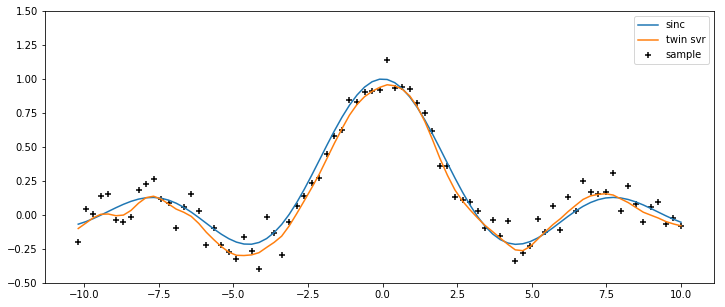

In [7]:
plt.figure(figsize=(12,5))
plt.plot(x,y,label='sinc')
plt.scatter(x,yhat,marker='+',label='sample',color='black')
plt.plot(x,pred,label='twin svr')
plt.ylim([-0.5,1.5])
plt.legend()

In [8]:
#Evaluation of the results:
def Evaluation_of_result(y,ypred):
    def mean_abs_error(y,ypred):
        return mean_absolute_error(y,ypred)
    def root_mean_sq_error(y,ypred):
        return math.sqrt(mean_squared_error(y,ypred))
    def SSE(y,ypred):
        y.reshape(-1,1)
        ypred.reshape(-1,1)
        return mean_squared_error(y,ypred)*(y.shape[0])
    def SST(y):
        y.reshape(-1,1)
        return np.var(y)*(y.shape[0])
    def SSR(ypred):
        ypred.reshape(-1,1)
        return np.var(ypred)*(ypred.shape[0])
    print("MAE: ",mean_abs_error(y,ypred))
    print("RMSE: ",root_mean_sq_error(y,ypred))
    print("SSE: ",SSE(y,ypred))
    print("SSR: ",SSR(ypred))
    print("SST: ",SST(y))
    print("SSR/SST: ",SSR(ypred)/SST(y))
    print("SSE/SST: ",SSE(y,ypred)/SST(y))

In [9]:
print("The evaluation of results of Twin SVR are as follows:")
Evaluation_of_result(y,pred)

The evaluation of results of Twin SVR are as follows:
MAE:  0.04668909092448037
RMSE:  0.055373344392855954
SSE:  0.24836278880923637
SSR:  9.785364166352997
SST:  9.942618950174554
SSR/SST:  0.9841837664090711
SSE/SST:  0.024979614531529047
